In [2]:
#import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage as ndi
from skimage import feature

## Prepare Event File For Edge Detection 
-  Open event file in ds9, make an annulus region around any bright sources and make new event file with bright source removed in xselect 
- If doing background subtraction later, this would be the time to make a background region file too

In [114]:
%cd ~

/Users/ellenthompson


In [115]:
#navigate to event file location
%cd Desktop/SL_Analysis/40111002002/event_cl/

/Users/ellenthompson/Desktop/SL_Analysis/40111002002/event_cl


In [18]:
%pwd

'/Users/ellenthompson/Desktop/SL_Analysis/30101053002/event_cl'

In [118]:
#plug in name of event file
name_of_event_file = "nu40111002002A01_cl.evt"

#define energy cut variables
energy_cut_channel_min = 36
energy_cut_channel_max = 209

#region file parameters (style options set to DS9 default, in image coords)
parameters_string = "#Region file format: DS9 version 4.1\nglobal color=green dashlist=8 3 width=1 font= 'helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\npolygon"

#region file title, output location is same as input
region_file_title = "new_region.reg"

In [119]:
#open data
hdul = fits.open(name_of_event_file)

#move into 2nd hdu
data = hdul[1].data

#define variables for det1x, det1y, and PI
DET1X = data["DET1X"]
DET1Y = data["DET1Y"]
PI = data["PI"]

## Energy Cut (might remove this option entirely)
- User defined low and high channels 
    - could rewrite to take in ev values instead
- Need to determine best bounds for SL? Variation differs between event files

In [120]:
#energy cut using PI column (background varies more across high than low energies)
del_PI_indices = [i for i, x in enumerate(PI) if x<=energy_cut_channel_min or x>=energy_cut_channel_max]
cut_DET1X = np.delete(DET1X, del_PI_indices)
cut_DET1Y = np.delete(DET1Y, del_PI_indices)

## Canny Edge Detection
- Note: plots generated here are oriented differently than when event file is loaded into ds9 but no translations necessary for region file to be correct
- Currently need to adjust sigma case-by-case such that plot shows no non-SL region edges identified as edges
- Currently finds edges for full region, have written some code that divides by detector 

In [121]:
#generate region file image WITH energy cut
cut_counts_arrays = np.histogram2d(cut_DET1X, cut_DET1Y, [360,360], range=[[0,360],[0,360]])
cut_counts = np.hstack(cut_counts_arrays[0])
cut_counts_binned = np.split(cut_counts,360)
im = np.column_stack(cut_counts_binned)

#im = ndi.rotate(im,90)

In [21]:
#generate region file WITHOUT energy cut
counts_arrays = np.histogram2d(DET1X,DET1Y, [360,360], range=[[0,360],[0,360]])
counts = np.hstack(counts_arrays[0])
counts_binned = np.split(counts,360)
im = np.column_stack(counts_binned)

In [122]:
#calculate standard deviation - this rule doesn't always work, often need to adjust sigma case-by-case
#returns same value for cut and uncut data
sigma = 10*np.std(cut_counts)

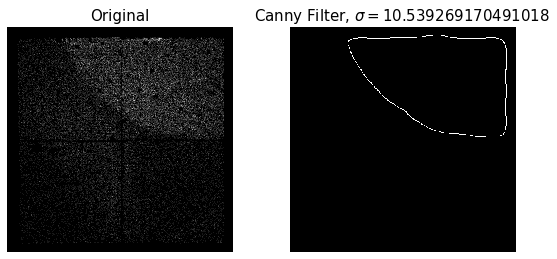

In [123]:
#compute the Canny filter, adjust sigma as necessary 
edges = feature.canny(im, sigma=sigma)
#display results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Original', fontsize=15)

ax2.imshow(edges, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny Filter, $\sigma='+str(sigma)+'$', fontsize=15)
#ax2.set_title(r'Canny Filter, $\sigma=8$', fontsize=15)

fig.tight_layout()

plt.show()

## Get Region File Coordinates
- Have only tried running for majority Detector 3 SL, may need to tweak for different orientations

In [376]:
#edges = np.transpose(edges)
#edges = ndi.rotate(edges,270)

In [19]:
type(edges)

numpy.ndarray

In [73]:
indices = np.where(edges != [0])
coordinates = zip(indices[1], indices[0])
coords_list = list(coordinates)
corners = np.hstack(coords_list)

In [46]:
##contour detection
import numpy as np
import cv2

im = cv2.imread('canny_edge_region.png')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


In [60]:
corners = np.vstack(np.vstack(np.vstack(contours)))

In [64]:
corners = np.hstack(corners)

In [80]:
type(indices)

tuple

In [90]:
##contour detection
import numpy as np
import cv2

im = cv2.imread('canny_edge.png')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


In [126]:
#get detected edge coordinates 
indices = np.where(edges != [0])
x_coords = list(indices[1])
y_coords = list(indices[0])

#identify region polygon corners, start with deleting duplicate x coords
region_cols = list(set(x_coords)) 

#find SL curve perimeter coords
curve_perimeter_coords = []
for i in region_cols:
    if i in curve_perimeter_coords:
            pass
    else:
        curve_perimeter_coords.append(i)
        y_coord_indices =[j for j, x in enumerate(x_coords) if x == i]
        y_coords_for_i = []
        for i in y_coord_indices:
            y_coords_for_i.append(y_coords[i])
        curve_perimeter_coords.append(max(y_coords_for_i))

#start listing polygon corners with curve perimeter 
corners = []
for i in curve_perimeter_coords:
    corners.append(i)

#identify and add edge corners
upper_right_x = max(x_coords)
upper_right_y = curve_perimeter_coords[-1]
lower_right_x = max(x_coords)
lower_right_y = min(y_coords)
lower_left_x = min(x_coords)
lower_left_y = min(y_coords)

edge_corners = (upper_right_x,upper_right_y,lower_right_x,lower_right_y,lower_left_x,lower_left_y)

for i in edge_corners:
    corners.append(i)

# the one that works is here ellen


In [128]:
#get detected edge coordinates 
indices = np.where(edges != [0])
x_coords = list(indices[1])
y_coords = list(indices[0])

#identify region polygon corners, start with deleting duplicate x coords
region_cols = list(set(x_coords)) 

#find SL curve perimeter coords left to right
curve_perimeter_coords_1 = []
for i in region_cols:
    if i in curve_perimeter_coords_1:
            pass
    else:
        curve_perimeter_coords_1.append(i)
        y_coord_indices =[j for j, x in enumerate(x_coords) if x == i]
        y_coords_for_i = []
        for i in y_coord_indices:
            y_coords_for_i.append(y_coords[i])
        curve_perimeter_coords_1.append(max(y_coords_for_i))

#start listing polygon corners with curve perimeter 
corners = []
for i in curve_perimeter_coords:
    corners.append(i)
    

#loop back right to left
region_cols_2 = region_cols[::-1]

#find SL curve perimeter coords right to left
curve_perimeter_coords_2 = []
for i in region_cols_2:
    if i in curve_perimeter_coords_2:
            pass
    else:
        curve_perimeter_coords_2.append(i)
        y_coord_indices =[j for j, x in enumerate(x_coords) if x == i]
        y_coords_for_i = []
        for i in y_coord_indices:
            y_coords_for_i.append(y_coords[i])
        curve_perimeter_coords_2.append(min(y_coords_for_i))

#add 2nd half of coords to corners
for i in curve_perimeter_coords_2:
    corners.append(i)




In [129]:
corners

[92,
 28,
 93,
 31,
 94,
 36,
 95,
 39,
 96,
 42,
 97,
 44,
 98,
 46,
 99,
 48,
 100,
 49,
 101,
 51,
 102,
 53,
 103,
 54,
 104,
 56,
 105,
 58,
 106,
 59,
 107,
 61,
 108,
 63,
 109,
 64,
 110,
 66,
 111,
 68,
 112,
 69,
 113,
 71,
 114,
 72,
 115,
 74,
 116,
 75,
 117,
 77,
 118,
 78,
 119,
 80,
 120,
 81,
 121,
 82,
 122,
 83,
 123,
 85,
 124,
 86,
 125,
 87,
 126,
 88,
 127,
 89,
 128,
 90,
 129,
 91,
 130,
 92,
 131,
 93,
 132,
 94,
 133,
 95,
 134,
 97,
 135,
 98,
 136,
 99,
 137,
 100,
 138,
 101,
 139,
 102,
 140,
 103,
 141,
 104,
 142,
 105,
 143,
 106,
 144,
 107,
 145,
 108,
 146,
 110,
 147,
 111,
 148,
 112,
 149,
 113,
 150,
 114,
 151,
 115,
 152,
 115,
 153,
 116,
 154,
 117,
 155,
 118,
 156,
 119,
 157,
 119,
 158,
 120,
 159,
 121,
 160,
 121,
 161,
 122,
 162,
 123,
 163,
 123,
 164,
 124,
 165,
 124,
 166,
 125,
 167,
 126,
 168,
 126,
 169,
 127,
 170,
 128,
 171,
 128,
 172,
 129,
 173,
 130,
 174,
 130,
 175,
 131,
 176,
 131,
 177,
 132,
 178,
 132,
 179,
 13

In [101]:
indices = np.where(edges != [0])
coordinates = zip(indices[1], indices[0])
coords_list = list(coordinates)
corners = np.hstack(coords_list)

In [517]:
min(y_coords)

188

In [538]:
##UPPER SL REGION (DETECTORS 0 AND 1)

#get detected edge coordinates 
indices = np.where(edges != [0])
x_coords = list(indices[1])
y_coords = list(indices[0])

#start listing polygon corners with curve perimeter 
corners = []
upper_left_x = min(x_coords)
upper_left_y = max(y_coords)
upper_right_x = max(x_coords)
upper_right_y = max(y_coords)


edge_corners = (upper_left_x,upper_left_y,upper_right_x,upper_right_y)



In [413]:
edge_corners

(217, 346, 352, 346, 352, 189)

In [539]:
for i in edge_corners:
    corners.append(i)

#identify region polygon corners, start with deleting duplicate x coords
region_cols = list(set(x_coords)) 
region_cols = region_cols[::-1]


#find SL curve perimeter coords
curve_perimeter_coords = []
for i in region_cols:
    if i in curve_perimeter_coords:
            pass
    else:
        curve_perimeter_coords.append(i)
        y_coord_indices =[j for j, x in enumerate(x_coords) if x == i]
        y_coords_for_i = []
        for i in y_coord_indices:
            y_coords_for_i.append(y_coords[i])
        curve_perimeter_coords.append(min(y_coords_for_i))

lower_right_x = max(x_coords)
lower_left_y = curve_perimeter_coords[1]
corners.append(lower_right_x)
corners.append(lower_left_x)

for i in curve_perimeter_coords:
    corners.append(i)

In [735]:
##SEMI-CIRCLE ORIENTED ON LEFT
upper_right_x = min(x_coords)
upper_right_y = max(y_coords)

corners = []
corners.append(upper_right_x)
corners.append(upper_right_y)

#identify region polygon corners, start with deleting duplicate x coords
region_cols = list(set(x_coords)) 

#find SL curve perimeter coords
curve_perimeter_coords = []
for i in region_cols:
    if i in curve_perimeter_coords:
            pass
    if i == upper_right_x:
            pass
    else:
        curve_perimeter_coords.append(i)
        y_coord_indices =[j for j, x in enumerate(x_coords) if x == i]
        y_coords_for_i = []
        for i in y_coord_indices:
            y_coords_for_i.append(y_coords[i])
        curve_perimeter_coords.append(max(y_coords_for_i))

        


In [693]:
upper_right_y

315

In [691]:
curve_perimeter_coords[0]

16

In [694]:
curve_perimeter_coords[1]

112

In [736]:
x_coord_indices = [i for i, y in enumerate(y_coords) if y==min(y_coords)]
x_coords_for_i = []
for i in x_coord_indices:
    x_coords_for_i.append(x_coords[i])

lower_right_x = max(x_coords_for_i)


In [737]:
for i in curve_perimeter_coords:
    corners.append(i)

lower_right_x = lower_right_x
lower_right_y = min(y_coords)
lower_left_x = min(x_coords)
lower_left_y = min(y_coords)

for i in (lower_right_x,lower_right_y,lower_left_x,lower_left_y):
    corners.append(i)



In [13]:
contours = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

TypeError: Expected Ptr<cv::UMat> for argument 'image'

In [16]:
##contour detection
import numpy as np
import cv2

im = cv2.imread(edges)
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


SystemError: <built-in function imread> returned NULL without setting an error

In [96]:
corners = np.hstack(np.vstack(np.vstack(np.vstack(contours))))

In [97]:
corners

array([  0,   0,   0, ...,  32, 102,  32], dtype=int32)

# Write Region File

In [130]:
#write region file
region_file = open(region_file_title, "w")
region_file.write(parameters_string + str(tuple(corners)))
region_file.close()